# History

- Data Cleaning
- Data Visualisation
- Data Analysis

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import time
from datetime import datetime
from datetime import timezone
from SPARQLWrapper import SPARQLWrapper, JSON

%matplotlib inline

In [2]:
# Reading the data from history revisions
# Contains the revisions for all the selected items
revisions = pd.read_csv('/Users/tushi/PRJ/WikidataParsing/topics/data_with_revisions/history_revisions.csv')
items = pd.read_csv('/Users/tushi/PRJ/WikidataParsing/topics/data/history.csv')

In [4]:
print("Number of Revisions in History Dataset")
print(revisions.shape)
print("Number of Wikidata Items in History Dataset")
print(items.shape)

Number of Revisions in History Dataset
(87913, 12)
Number of Wikidata Items in History Dataset
(31190, 3)


# Data Cleaning

- Drop uneccessary columns
- Assign types for all edits
- Assign user types for all edits
- Remove rows with empty comments - better to remove after calculating the types in case there are some edge cases which have not been discovered
- Convert timestamps to datetime objects
- (Remove items that contain only bot edits)
- Remove items with editcounts < (If removing rows with empty comments will need to recalculate the edit count and merge with dataset)

In [5]:
# Dropping unecessary columns from the revisions dataframe
rev = revisions.drop(['pageid', 'type', 'editentity', 'parentid'], axis=1)

In [6]:
# Method to assign edit types to each revision by using the comment
def get_edit_type(comment):
    # Decoding the comment from a bytes object to a string
    # Converting the comment to lowercase
    # c = comment.decode("utf-8").lower()
    c = comment.lower()
    # print(c)
    editType = '' 
    
    if c == '':
        return editType
    
    if "|" in c:
        # Comments which have |
        cc = c.split("|")[0].replace("/* ", "")
        if 'undo' in cc:
            editType = 'undo'
            return editType
        elif 'restore' in cc:
            editType = 'restore'
            return editType
        elif 'wbsetclaimvalue' in cc:
            editType = 'set'
            return editType
        elif 'wbsetlabeldescriptionaliases' in cc:
            editType = 'set'
            return editType
        elif 'wbcreateredirect' in cc:
            editType = 'create'
            return editType
        elif 'merge' in cc:
            editType = 'merge'
            return editType
        elif '-' in cc:
            ccc = cc.split("-")[1]
            if 'create' in ccc:
                editType = 'create'
                return editType
            elif 'add' in ccc:
                editType = 'add'
                return editType
            elif 'set' in ccc:
                editType = 'set'
                return editType
            elif 'update' in ccc:
                editType = 'update'
                return editType
            elif 'remove' in ccc:
                editType = 'remove'
                return editType
    if 'revert' in c: 
        editType = 'revert'
        return editType  
    elif 'protect' in c:
        editType = 'protect'
        return editType  
    elif 'undid' in c:
        editType = 'undo'
        return editType      
    return editType
        

In [8]:
# Assigning edit types to each revision
rev['type'] = [get_edit_type(comment) for comment in rev['comment']]

In [10]:
rev.shape

(87913, 9)

In [11]:
# Removing revisions with empty types 
# Removing revisions that either had an empty comment or or an edge case
to_remove = rev[rev['type'] == ''].index
rev = rev.drop(to_remove)

In [13]:
# Reading csv with bot names scraped from Wikidata
bots = pd.read_csv('/Users/tushi/PRJ/WikidataParsing/wikidata_bots.csv')

In [14]:
# Method to assign user types to revisions
# 3 types: Registered, Anonymous, Bot
def get_user_type(user):
    
    u = user[1:].replace("'", "")
    
    userType = ''
    
    if u == "":
        userType = 'Anonymous'
        return userType
    elif u in bots.values:
        userType = 'Bot'
        return userType
    else: 
        userType = 'Registered'
        return userType
    return userType
    

In [15]:
# Assigning user types to revisions
rev['usertype'] = [get_user_type(user) for user in rev['username']]

In [16]:
# Need to recalculate editcount for the items
# Drop old editcount column
rev = rev.drop(['editscount'], axis=1)

In [17]:
editscount = rev['qid'].value_counts()

In [18]:
editscount.describe()

count    31055.000000
mean         2.809048
std          5.688518
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max        322.000000
Name: qid, dtype: float64

Rationale for Removing edits <= 5

- Research
- Range of edits is very large
- Median value that is the 50th percentile is 2 edits that is more than half the dataset has items that would not be very interesting to the research as we are interested in highly edited items
- Items in the 75th percentile have an editcount of 3 showing that only a small percentage of items - slightly greater than 25% of the items are those that can be deemed interesting
- Also important to note that given these values, the data could also contain a reasonable number of outliers - items which are highly edited but do not add value to the research - for example they do not contain reverts or they are sandbox items

In [19]:
# Converting to a dataframe so that it can be compared/merged with original dataframe
df_editscount = pd.DataFrame({'qid':editscount.index, 'editscount':editscount.values})

In [20]:
print('Items with No of Edits = 1')
print(len(df_editscount[df_editscount['editscount'] == 1]))

print('Items with No of Edits = 2')
print(len(df_editscount[df_editscount['editscount'] == 2]))

print('Items with No of Edits = 3')
print(len(df_editscount[df_editscount['editscount'] == 3]))

print('Items with No of Edits = 4')
print(len(df_editscount[df_editscount['editscount'] == 4]))

print('Items with No of Edits = 5')
print(len(df_editscount[df_editscount['editscount'] == 5]))

print('Items with No of Edits <= 5')
print(len(df_editscount[df_editscount['editscount'] <= 5]))

Items with No of Edits = 1
12923
Items with No of Edits = 2
9346
Items with No of Edits = 3
3329
Items with No of Edits = 4
1934
Items with No of Edits = 5
772
Items with No of Edits <= 5
28304


In [21]:
# Removing items with editscount <= 5 
to_remove = df_editscount[df_editscount['editscount'] <= 5].index
df_editscount = df_editscount.drop(to_remove)

In [22]:
df_editscount.shape

(2751, 2)

In [23]:
# Removing all items with editscount <= 5 from revisions dataset
# Removing by finding intersection on qid between bot sets
rev = pd.merge(rev, df_editscount, how='inner', on=['qid'])

In [25]:
# Converting the timestamps to datetime object
rev['timestamp'] = pd.to_datetime(rev.timestamp, format='%Y-%m-%d %H:%M:%S')

# Converting to datetime leaves the dates in form '2016-10-12 14:37:53+00:00'
# Formatting timestamp to remove +00:00
rev['timestamp'] = rev['timestamp'].dt.strftime('%Y-%m-%d %H:%M:%S')

# strftime() returns a string object
# Converting back to datetime
rev['timestamp'] = pd.to_datetime(rev.timestamp, format='%Y-%m-%d %H:%M:%S')

In [26]:
rev.dtypes

Unnamed: 0             int64
qid                   object
revisionid           float64
timestamp     datetime64[ns]
comment               object
userid               float64
username              object
type                  object
usertype              object
editscount             int64
dtype: object

In [27]:
# Sparql Query to get labels using Qids
def get_item_label(qid):
    try:        
        # Specifying the Wikidata SPARQL endpoint
        sparql = SPARQLWrapper("https://query.wikidata.org/sparql")
        
        # Query to access the label for the wikidata item
        sparql.setQuery('PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#> SELECT ?label WHERE {wd:' + qid + ' rdfs:label ?label . SERVICE wikibase:label { bd:serviceParam wikibase:language "en". } } LIMIT 1')
        
        # Converting result to JSON format
        sparql.setReturnFormat(JSON)
        result = sparql.query().convert()
        
        # result is in the form of "bindings" which are a list of dictionaries
        # Accessing the value of the label 
        itemLabel = result["results"]["bindings"][0]["label"]["value"]
        
        return itemLabel
    except Exception as ex:
        print(ex)
        return('')

In [28]:
print(df_editscount.head())

         qid  editscount
0     Q77389         322
1  Q11718707         316
2   Q3126992         310
3   Q2476721         309
4   Q1565364         241


# Descriptive Statistics

In [29]:
rev['editscount'].describe().astype(int)

count    34037
mean        32
std         62
min          6
25%          8
50%         13
75%         24
max        322
Name: editscount, dtype: int32

In [30]:
rev['type'].describe()

count      34037
unique        10
top       create
freq       16463
Name: type, dtype: object

In [31]:
history_items = rev['qid'].value_counts()

In [32]:
# converting a series to a dataframe
h_items = pd.DataFrame({'type':history_items.index, 'count':history_items.values})

In [33]:
# Items between the median and 75th percentile
h_items[(h_items['count'] >= 13) & (h_items['count'] <= 24)]

,type,count
174,Q27652636,24
175,Q21543333,24
176,Q27095566,24
177,Q27609554,24
178,Q27916603,24
...,...,...
738,Q336868,13
739,Q18713531,13
740,Q27917025,13
741,Q24956329,13


# Statistics for Proxies

In [34]:
# Counting the value of the number of proxies that exist in the dataset
type_stats = rev['type'].value_counts()

In [35]:
# Converting a series to a Dataframe
type_s = pd.DataFrame({'type':type_stats.index, 'count':type_stats.values})
ts = type_s.set_index('type')
print(ts)

         count
type          
create   16463
add      10901
update    4021
remove    1216
set       1196
revert     102
undo        57
merge       52
restore     27
protect      2


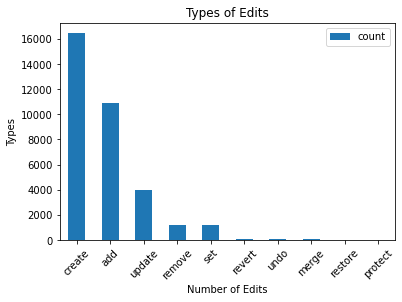

In [36]:
# Plotting the statistics for the proxies/types of edits in the data
ax = ts.plot.bar()

plt.title('Types of Edits')
plt.xlabel('Number of Edits')
plt.ylabel('Types')

plt.xticks(rotation=45)

plt.show()

In [39]:
# Extracting select proxies: remove, restore, revert, merge, undo, protect
controversial_proxies = ts.iloc[[3, 5, 6, 7, 8, 9]]
# print(controversial_proxies)

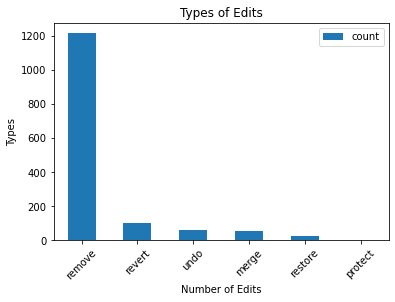

In [40]:
# Plotting select proxies
ax = controversial_proxies.plot.bar()

plt.title('Types of Edits')
plt.xlabel('Number of Edits')
plt.ylabel('Types')

plt.xticks(rotation=45)

# ax.invert_yaxis()

plt.show()

In [41]:
# Extracting select proxies: restore, revert, merge, undo, protect
controversial_proxies_without_remove = ts.iloc[[5, 6, 7, 8, 9]]
print(controversial_proxies_without_remove)

         count
type          
revert     102
undo        57
merge       52
restore     27
protect      2


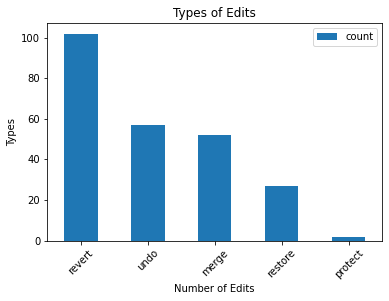

In [42]:
# Plotting select proxies without remove
ax = controversial_proxies_without_remove.plot.bar()

plt.title('Types of Edits')
plt.xlabel('Number of Edits')
plt.ylabel('Types')

plt.xticks(rotation=45)

# ax.invert_yaxis()

plt.show()

Note: No of reverts > undo, most of the previously seen topics had undo > reverts.

Also there is atleast a difference of 45 between revert and undo. why are the reverts more?

# Statistics for No of Edits

In [43]:
no_of_edits = history_items.to_numpy()

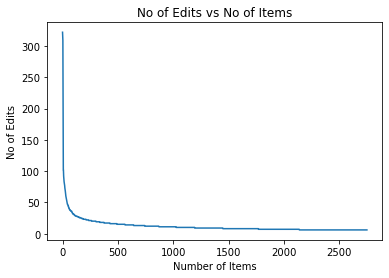

In [44]:
# Plotting No of Edits for the Items in the dataset 
# Line Plot

plt.plot(no_of_edits)

plt.title("No of Edits vs No of Items")
plt.xlabel("Number of Items")
plt.ylabel("No of Edits")

plt.show()

In [45]:
# Top 25% of the dataset

# Grouping by Proxies

In [46]:
reverts = rev["type"].str.contains("revert")
revert_edits = reverts.groupby(rev["qid"], sort=False).sum().astype(np.uintc)

In [47]:
merges = rev["type"].str.contains("merge")
merge_edits = merges.groupby(rev["qid"], sort=False).sum().astype(np.uintc)

In [48]:
undos = rev["type"].str.contains("undo")
undo_edits = undos.groupby(rev["qid"], sort=False).sum().astype(np.uintc)

In [49]:
restores = rev["type"].str.contains("restore")
restore_edits = restores.groupby(rev["qid"], sort=False).sum().astype(np.uintc)

In [50]:
protects = rev["type"].str.contains("protect")
protect_edits = protects.groupby(rev["qid"], sort=False).sum().astype(np.uintc)

In [51]:
removes = rev["type"].str.contains("remove")
remove_edits = removes.groupby(rev["qid"], sort=False).sum().astype(np.uintc)

In [52]:
# Creating a dataframe which will contain qids for items and no of each proxy
proxies = pd.DataFrame({'revert': revert_edits, 'merge': merge_edits, 'undo': undo_edits, 'restore': restore_edits, 
                        'protect': protect_edits, 'remove': remove_edits})

In [53]:
proxies = proxies.reset_index()

In [54]:
proxies.columns

Index(['qid', 'revert', 'merge', 'undo', 'restore', 'protect', 'remove'], dtype='object')

In [55]:
df_editscount.columns

Index(['qid', 'editscount'], dtype='object')

In [56]:
# Adding editscount for each item 
proxies = pd.merge(proxies, df_editscount, how='inner', on=['qid'])

In [57]:
# Counting the number of users per item that is userscount
rev_users = rev.groupby('qid')['username'].nunique()
# Converting to a dataframe so that it can be compared/merged 
df_userscount = pd.DataFrame({'qid':rev_users.index, 'userscount':rev_users.values})

In [58]:
# Adding userscount for each item 
proxies = pd.merge(proxies, df_userscount, how='inner', on=['qid'])

In [59]:
proxies.describe()

,revert,merge,undo,restore,protect,remove,editscount,userscount
count,2751.000000,2751.000000,2751.00000,2751.000000,2751.000000,2751.000000,2751.000000,2751.000000
mean,0.037077,0.018902,0.02072,0.009815,0.000727,0.442021,12.372592,3.065431
std,0.367902,0.141443,0.19430,0.121708,0.026958,1.124682,15.935017,1.932330
min,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,6.000000,1.000000
25%,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,7.000000,2.000000
50%,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,9.000000,3.000000
75%,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,13.000000,4.000000
max,10.000000,2.000000,5.00000,3.000000,1.000000,26.000000,322.000000,33.000000


Text(0, 0.5, 'No of Edits')

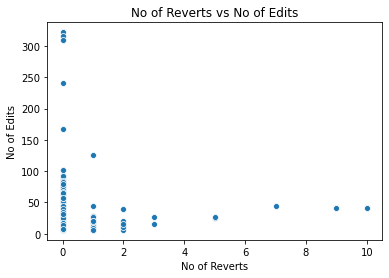

In [60]:
ax = sns.scatterplot(x="revert", y="editscount", data=proxies)
ax.set_title("No of Reverts vs No of Edits")
ax.set_xlabel("No of Reverts")
ax.set_ylabel("No of Edits")
# No of reverts are very low for highly edited items

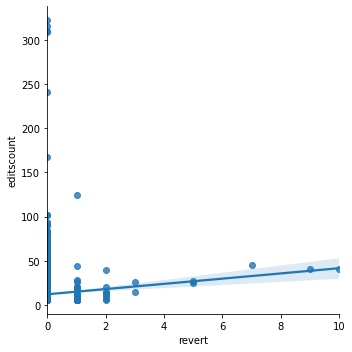

In [61]:
sns.lmplot(x="revert", y="editscount", data=proxies)

In [62]:
corr_matrix = proxies.corr()
corr_matrix
# merge and editscount have a negative correlation

,revert,merge,undo,restore,protect,remove,editscount,userscount
revert,1.000000,0.112311,0.299557,0.674046,0.510582,0.064958,0.068106,0.319349
merge,0.112311,1.000000,0.051902,0.073714,0.187127,0.068611,-0.002642,0.120537
undo,0.299557,0.051902,1.000000,0.145170,0.066546,0.114494,0.057521,0.120360
restore,0.674046,0.073714,0.145170,1.000000,0.330316,0.037366,0.058863,0.244662
protect,0.510582,0.187127,0.066546,0.330316,1.000000,-0.010603,0.034922,0.131719
remove,0.064958,0.068611,0.114494,0.037366,-0.010603,1.000000,0.202575,0.256078
editscount,0.068106,-0.002642,0.057521,0.058863,0.034922,0.202575,1.000000,0.161471
userscount,0.319349,0.120537,0.120360,0.244662,0.131719,0.256078,0.161471,1.000000


In [63]:
# restore and revert
# undo and revert
# protect and revert
# userscount and revert
# protect and restore
# look at negative correlations

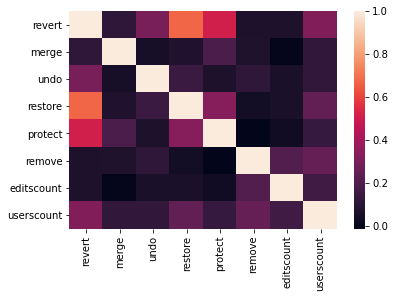

In [64]:
sns.heatmap(corr_matrix)

In [65]:
# restore and revert have a positive correlation - imp

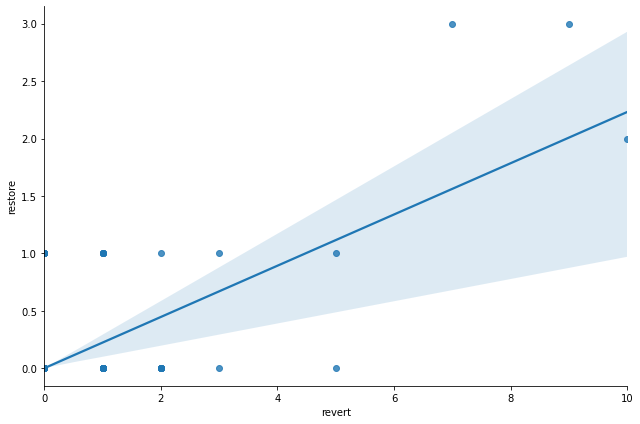

In [66]:
# restore and revert have some correlation - weak positive
sns.lmplot(x="revert", y="restore", data=proxies, height=6, aspect=1.5)

Text(0, 0.5, 'No of Edits')

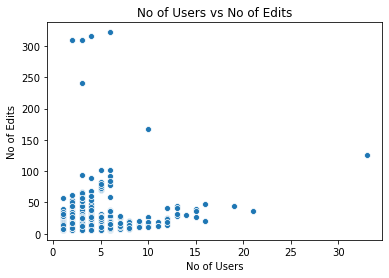

In [67]:
ax = sns.scatterplot(x="userscount", y="editscount", data=proxies)
ax.set_title("No of Users vs No of Edits")
ax.set_xlabel("No of Users")
ax.set_ylabel("No of Edits")

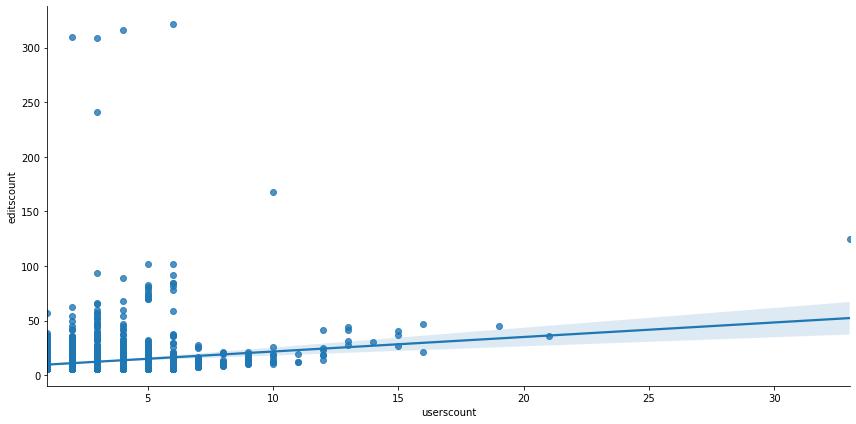

In [68]:
sns.lmplot(x="userscount", y="editscount", data=proxies, height=6, aspect=2)

In [69]:
# Removing items with 0 reverts, merges, undos, restores, removes, protects
# Removing items with editscount <= 5 
to_remove = proxies[(proxies['revert'] == 0) & (proxies['merge'] == 0) & (proxies['undo'] == 0) & (proxies['restore'] == 0) & 
                   (proxies['remove'] == 0) & (proxies['protect'] == 0)].index
proxies = proxies.drop(to_remove)

In [70]:
proxies.shape

(749, 9)

In [72]:
proxies.tail()

,qid,revert,merge,undo,restore,protect,remove,editscount,userscount
2725,Q28060026,0,0,0,0,0,1,7,1
2734,Q28070854,0,0,0,0,0,2,27,2
2735,Q28071234,0,0,0,0,0,1,9,1
2736,Q28072639,0,0,0,0,0,2,34,1
2743,Q28085946,0,0,0,0,0,1,25,3
